## 1. Setup

In [1]:
## import packages

import os
import numpy as np
import pandas as pd
from scipy import stats

import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # livin' wild

plt.rcParams['figure.dpi'] = 200

In [2]:
## Lists of GLTs that correspond to a given date
# @jean: 2022-02-24 didn't show up in the SHIFT Ecosphere paper, but it is on the server? What's up with that?
date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']

# Directory structure...
glt_dir = 'D:/SHIFT/raw_imagery/glts'
all_glts = [f for f in os.listdir(glt_dir) if not f.endswith('.hdr')]
img_dir = 'D:/SHIFT/raw_imagery/L2A'
all_imgs = [f for f in os.listdir(img_dir) if not f.endswith('.hdr')]

# Shapefile containing TOI's (trees of interest)
trees_shp_path = ('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/gis_data/all_trees.shp')

In [3]:
## Functions for GLT lookup

# Retrieves spectrum from a given image/GLT combo at a given lat/lon
def get_pixel_value(image_path, glt_path, lat, lon, coords_epsg):
    image = rxr.open_rasterio(image_path)
    glt = rxr.open_rasterio(glt_path)
    glt_epsg = glt.rio.crs.to_epsg()
    if glt_epsg != coords_epsg:    # if the GLT and the input coordinates are in different projections, convert the coordinates to the GLT projection
        coords = gpd.GeoDataFrame({'geometry': gpd.points_from_xy([lon], [lat])}, crs=coords_epsg)
        coords = coords.to_crs(glt_epsg)
        lat = coords.geometry.y[0]
        lon = coords.geometry.x[0]
    try:
        closest_point = glt.sel(x=lon+2.4, y=lat+2.4, method='nearest', tolerance=2.5)
    except KeyError:
        none_object = (rxr.open_rasterio(image_path).wavelength.values, np.zeros(len(rxr.open_rasterio(image_path).wavelength.values)), 'No Data Available')    # return this if no data is found
        return none_object
    if (closest_point.values[0] == 0 and closest_point.values[1] == 0):
        none_object = (rxr.open_rasterio(image_path).wavelength.values, np.zeros(len(rxr.open_rasterio(image_path).wavelength.values)), 'No Data Available')    # return this if no data is found
        return none_object
    closest_x = int(closest_point[0].values[()])-1
    closest_y = int(closest_point[1].values[()])-1
    pixel_value = image.isel(x=closest_x, y=closest_y)
    print(closest_x, closest_y)
    return pixel_value

# Parses a list of GLTs and returns a list of spectra that correspond to the provided lat/lon, plus list of GLT that were used
def find_and_get_pixel_value(list_of_img_paths, list_of_glt_paths, lat, lon, coords_epsg):
    list_of_img_paths.sort()
    list_of_glt_paths.sort()    # sort the lists to ensure that the GLT and image are from the same time
    none_object = (rxr.open_rasterio(list_of_img_paths[0]).wavelength.values, np.zeros(len(rxr.open_rasterio(list_of_img_paths[0]).wavelength.values)), 'No Data Available')    # return this if no data is found
    specs = []
    glts_used = []
    for i in range(len(list_of_img_paths)):
        try:
            this_val = get_pixel_value(list_of_img_paths[i], list_of_glt_paths[i], lat, lon, coords_epsg)
            if this_val[2] == 'No Data Available':
                continue
            specs.append(this_val)
            glts_used.append(list_of_glt_paths[i].split('\\')[-1])
        except IndexError:
            continue
    
    if len(specs) > 1:
        # When there are two spectra for the same location, it is likely that one is the forward scattering and the other is the back scattering
        # We want the backscattering view, so we find the one that has the higher average reflectance in the NIR region
        avg_refl = [stats.trim_mean(spec[130:145], 0.1) for spec in specs]     # Trim the mean to exclude big outliers
        good_spec = specs[avg_refl.index(max(avg_refl))]
        good_glt = glts_used[avg_refl.index(max(avg_refl))] 
    if len(specs) == 0:
        return none_object
    if len(specs) == 1:
        good_spec = specs[0]
        good_glt = glts_used[0]
    return good_spec.wavelength.values, good_spec.values, good_glt

# outputs dataframe containing spectra from shapefile points
def shapefile_to_spectra(shapefile_path, list_of_img_paths, list_of_glt_paths):
    shapefile = gpd.read_file(shapefile_path)
    shapefile_epsg = shapefile.crs.to_epsg()
    shapefile_specs = []
    glts_used = []
    for i in range(len(shapefile)):
        lat = shapefile.geometry.y[i]
        lon = shapefile.geometry.x[i]
        output = find_and_get_pixel_value(list_of_img_paths, list_of_glt_paths, lat, lon, shapefile_epsg)
        shapefile_specs.append(output[1])
        glts_used.append(output[2])


    wavelengths = find_and_get_pixel_value(list_of_img_paths, list_of_glt_paths, lat, lon, shapefile_epsg)[0]

    shapefile_specs_array = np.stack(shapefile_specs, axis=0)
    df = pd.DataFrame(shapefile_specs_array.T, columns=shapefile.Comment).set_index(wavelengths)
    df.columns.name = 'Wavelength'
    return df, glts_used

## 2. Testing for one point...

D:/SHIFT/raw_imagery/L2A\ang20220914t183017_rfl
D:/SHIFT/raw_imagery/glts\ang20220914t183017_glt
(lat1, lon1) = (34.69003185179147, -120.04807342091634)
428 9698


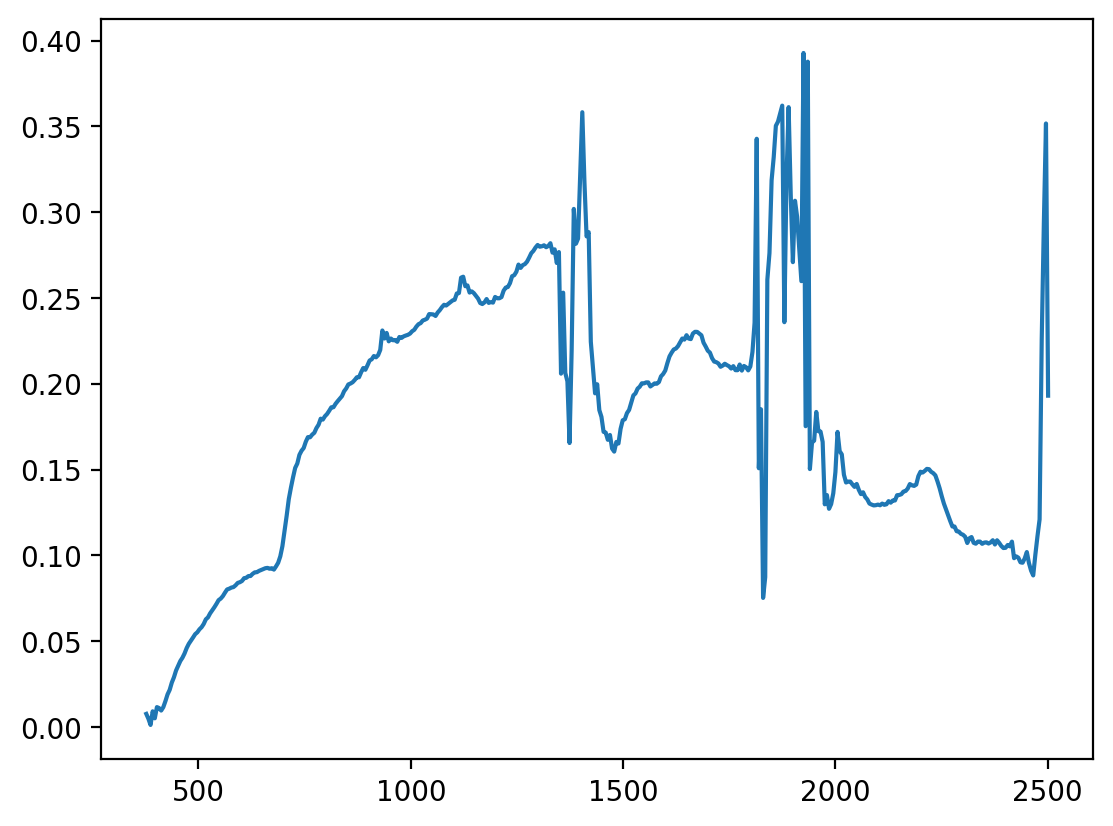

In [17]:
# setting up for testing the functions...
date1 = date_list[-1]
glt_list1 = [glt for glt in all_glts if glt[3:11] == date1]
img_list1 = [img for img in all_imgs if img[3:11] == date1]
img_list1 = [os.path.join(img_dir, img) for img in img_list1]
glt_list1 = [os.path.join(glt_dir, glt) for glt in glt_list1]
glt_list1.sort()
img_list1.sort()

image_path1 = img_list1[0]
glt_path1 = glt_list1[0]
print(image_path1)
print(glt_path1)

shapefile1 = gpd.read_file(trees_shp_path)
coords_epsg1 = shapefile1.crs.to_epsg()

i1 = 0  # i1 is the index of the tree we're testing
lat1 = shapefile1.geometry.y[i1]
lon1 = shapefile1.geometry.x[i1]
print('(lat1, lon1) =', (lat1, lon1))

# this is where we're actually testing the function contents
image1 = rxr.open_rasterio(image_path1)
glt1 = rxr.open_rasterio(glt_path1)
glt_epsg1 = glt1.rio.crs.to_epsg()
if glt_epsg1 != coords_epsg1:    # if the GLT and the input coordinates are in different projections, convert the coordinates to the GLT projection
    coords1 = gpd.GeoDataFrame({'geometry': gpd.points_from_xy([lon1], [lat1])}, crs=coords_epsg1)
    coords1 = coords1.to_crs(glt_epsg1)
    lat1 = coords1.geometry.y[0]
    lon1 = coords1.geometry.x[0]
try:
    closest_point1 = glt1.sel(x=lon1+2.4, y=lat1+2.4, method='nearest', tolerance=2.5)
except KeyError:
    none_object1 = (rxr.open_rasterio(image_path1).wavelength.values, np.zeros(len(rxr.open_rasterio(image_path1).wavelength.values)), 'No Data Available')    # return this if no data is found
    print('oops, no data')
if (closest_point1.values[0] == 0 and closest_point1.values[1] == 0):
    none_object1 = (rxr.open_rasterio(image_path1).wavelength.values, np.zeros(len(rxr.open_rasterio(image_path1).wavelength.values)), 'No Data Available')    # return this if no data is found
    print('oops, no data')
closest_x1 = int(closest_point1[0].values[()])-1
closest_y1 = int(closest_point1[1].values[()])-1
pixel_value1 = image1.isel(x=closest_x1, y=closest_y1)
print(closest_x1, closest_y1)

plt.plot(pixel_value1.wavelength, pixel_value1.values)
plt.show()

D:/SHIFT/raw_imagery/L2A\ang20220914t183017_rfl
D:/SHIFT/raw_imagery/glts\ang20220914t183017_glt
(lat, lon) = (34.69003185179147, -120.04807342091634)
428 9698


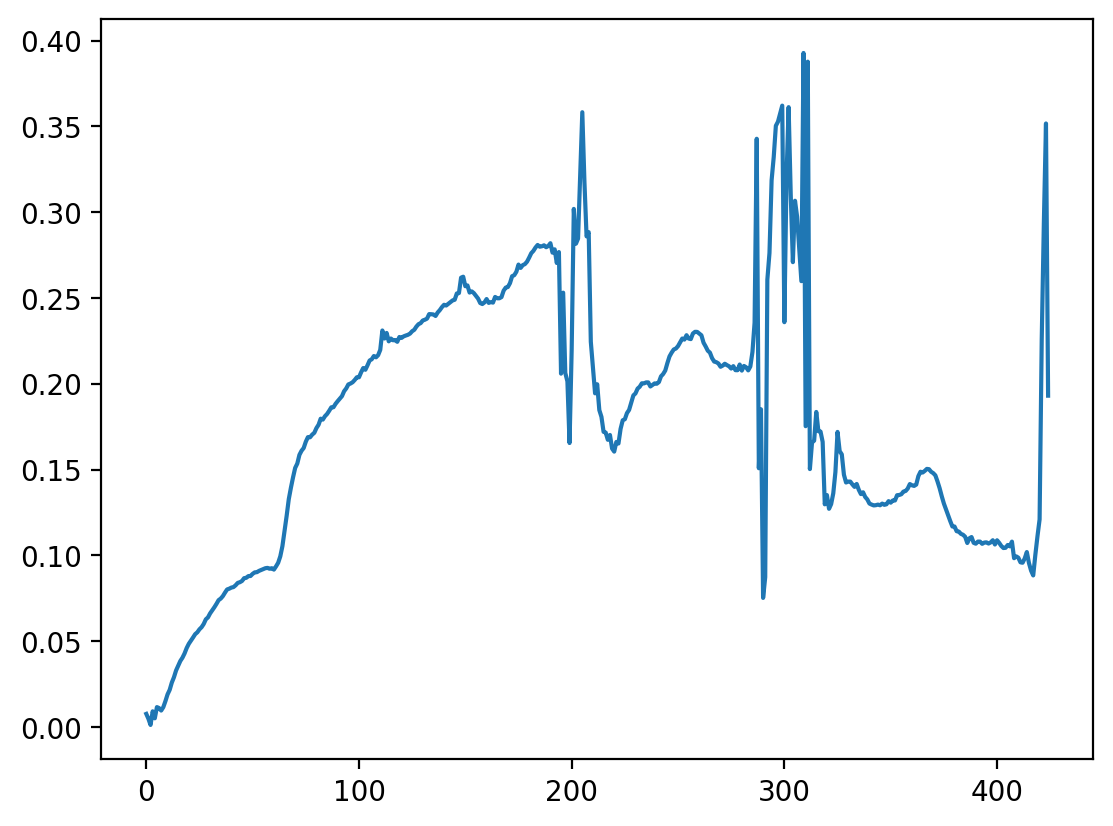

In [18]:
# now try it again with the function
# setting up for testing the functions...
date = date_list[-1]
glt_list = [glt for glt in all_glts if glt[3:11] == date]
img_list = [img for img in all_imgs if img[3:11] == date]
img_list = [os.path.join(img_dir, img) for img in img_list]
glt_list = [os.path.join(glt_dir, glt) for glt in glt_list]
glt_list.sort()
img_list.sort()

image_path = img_list[0]
glt_path = glt_list[0]
print(image_path)
print(glt_path)

shapefile = gpd.read_file(trees_shp_path)
coords_epsg = shapefile.crs.to_epsg()

i = 0  # i is the index of the tree we're testing
lat = shapefile.geometry.y[i]
lon = shapefile.geometry.x[i]
print('(lat, lon) =', (lat, lon))

output = get_pixel_value(image_path, glt_path, lat, lon, coords_epsg)
plt.plot(output)

## 3. Testing for one date...

In [13]:
date = date_list[-1]
print(date)

glt_list = [glt for glt in all_glts if glt[3:11] == date]
img_list = [img for img in all_imgs if img[3:11] == date]

# Get spectra for all trees
spectra = shapefile_to_spectra(trees_shp_path, [os.path.join(img_dir, img) for img in img_list], [os.path.join(glt_dir, glt) for glt in glt_list])

20220914
428 9698
['ang20220914t183017_glt']
-428 -9701
['ang20220914t183017_glt']
422 9701
['ang20220914t183017_glt']
422 9702
['ang20220914t183017_glt']
412 9698
['ang20220914t183017_glt']
419 9705
['ang20220914t183017_glt']
426 9715
['ang20220914t183017_glt']
424 9717
['ang20220914t183017_glt']
426 9716
['ang20220914t183017_glt']
427 9715
['ang20220914t183017_glt']
426 9716
['ang20220914t183017_glt']
427 9716
['ang20220914t183017_glt']
428 9715
['ang20220914t183017_glt']
428 9715
['ang20220914t183017_glt']
428 9714
['ang20220914t183017_glt']
-432 -9717
['ang20220914t183017_glt']
430 9713
['ang20220914t183017_glt']
430 9713
['ang20220914t183017_glt']
431 9714
['ang20220914t183017_glt']
431 9712
['ang20220914t183017_glt']
431 9712
['ang20220914t183017_glt']
433 9712
['ang20220914t183017_glt']
432 9715
['ang20220914t183017_glt']
438 9714
['ang20220914t183017_glt']
439 9710
['ang20220914t183017_glt']
442 9710
['ang20220914t183017_glt']
446 9712
['ang20220914t183017_glt']
-427 -9743
['an

In [14]:
# spectra[0].to_csv(f'D:/SHIFT/extracted_data/spectra/{date}_tree_spectra.csv')

trees = gpd.read_file(trees_shp_path).rename(columns={'Comment': 'Tree_ID'})
trees['GLTs'] = spectra[1]
trees['Latitude'] = trees.geometry.y
trees['Longitude'] = trees.geometry.x
# trees[['Tree_ID', 'Latitude', 'Longitude', 'GLTs']].to_csv(f'D:/SHIFT/extracted_data/spectra/{date}_tree_spectra_metadata.csv', index=False)

Text(0.5, 1.0, 'Tree Spectra 20220914')

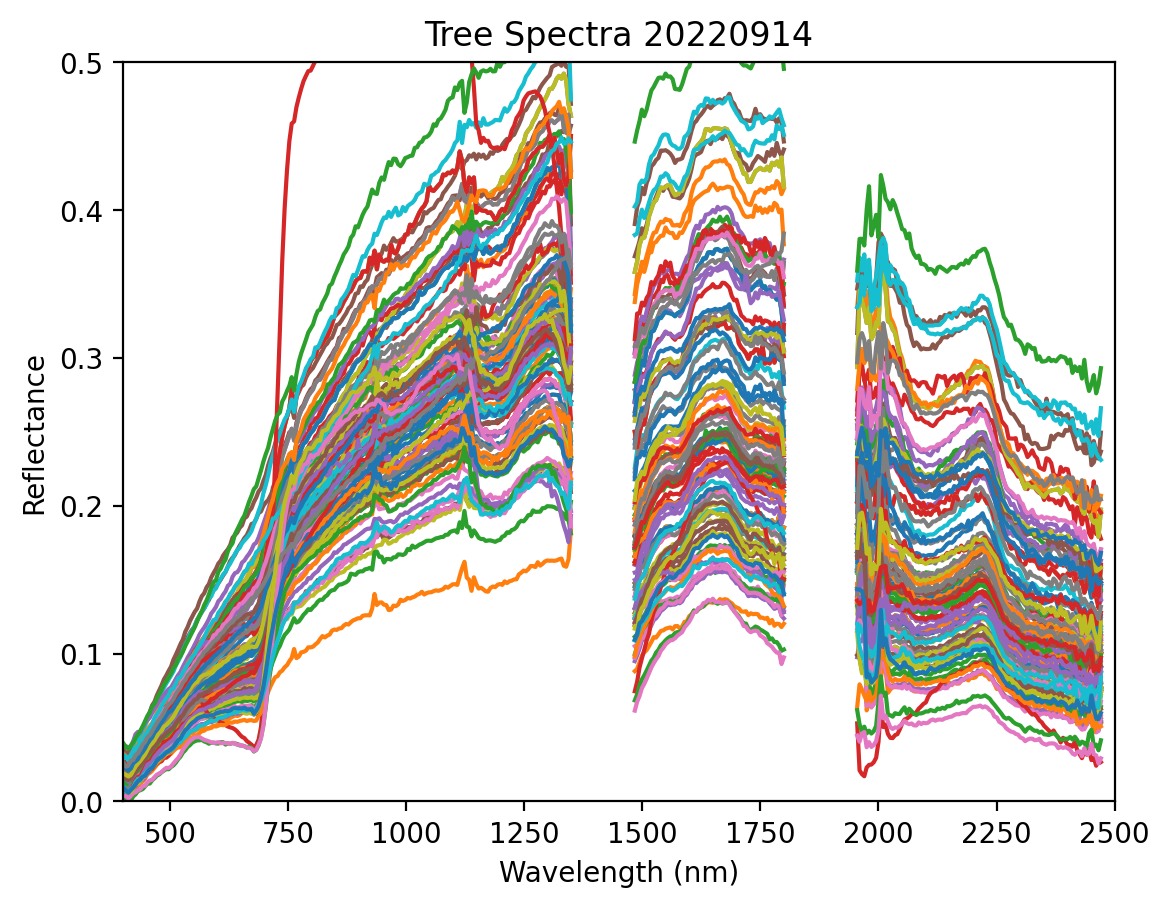

In [15]:
wavelengths = spectra[0].index.to_numpy()
wl_nan = wavelengths.copy()
wl_nan[wavelengths < 400] = np.nan 
wl_nan[wavelengths > 2475] = np.nan 
wl_nan[np.logical_and(wavelengths > 1350, wavelengths < 1480)] = np.nan 
wl_nan[np.logical_and(wavelengths > 1800, wavelengths < 1950)] = np.nan 
for tree in spectra[0].columns:
    plt.plot(wl_nan, spectra[0][tree], label=tree)

plt.xlim(400, 2500)
plt.ylim(0, 0.5)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Tree Spectra '+date)


## 4. Extracting Spectra for All Dates

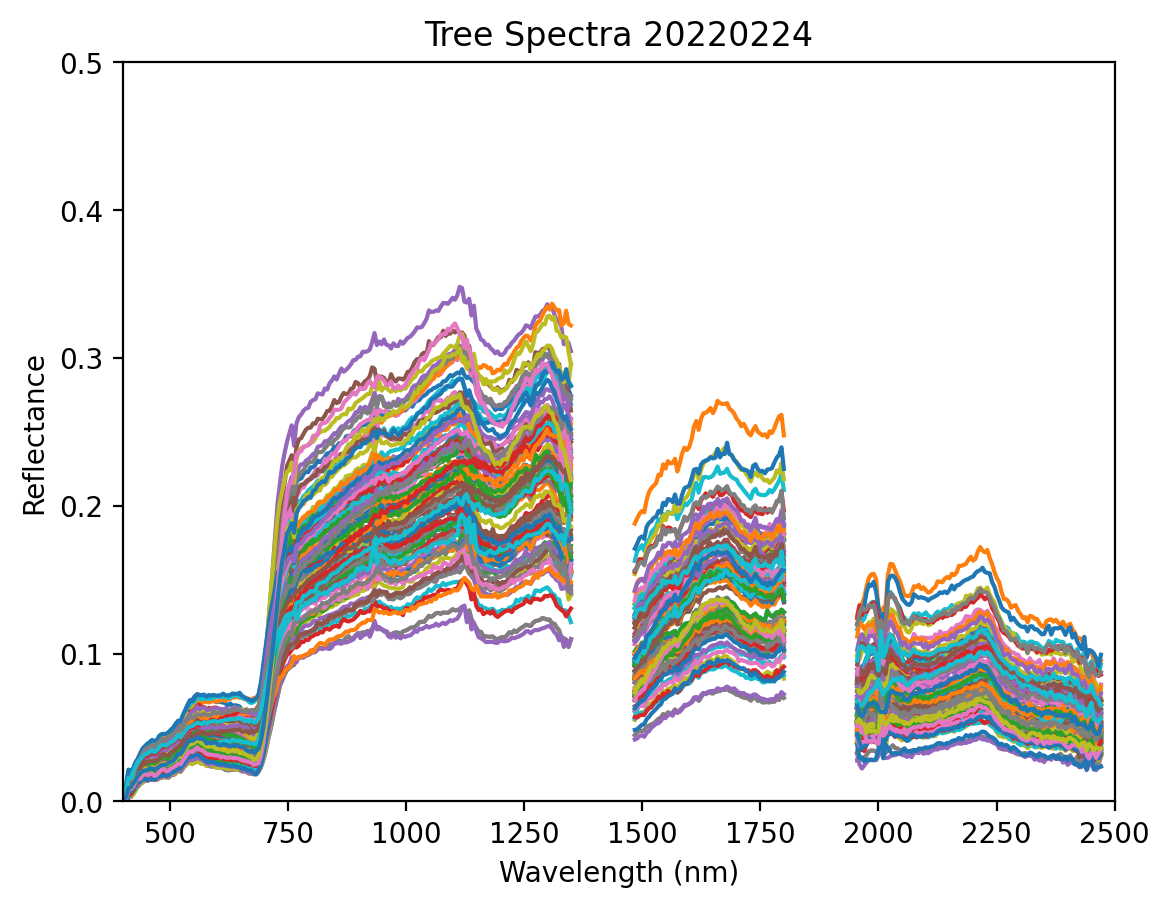

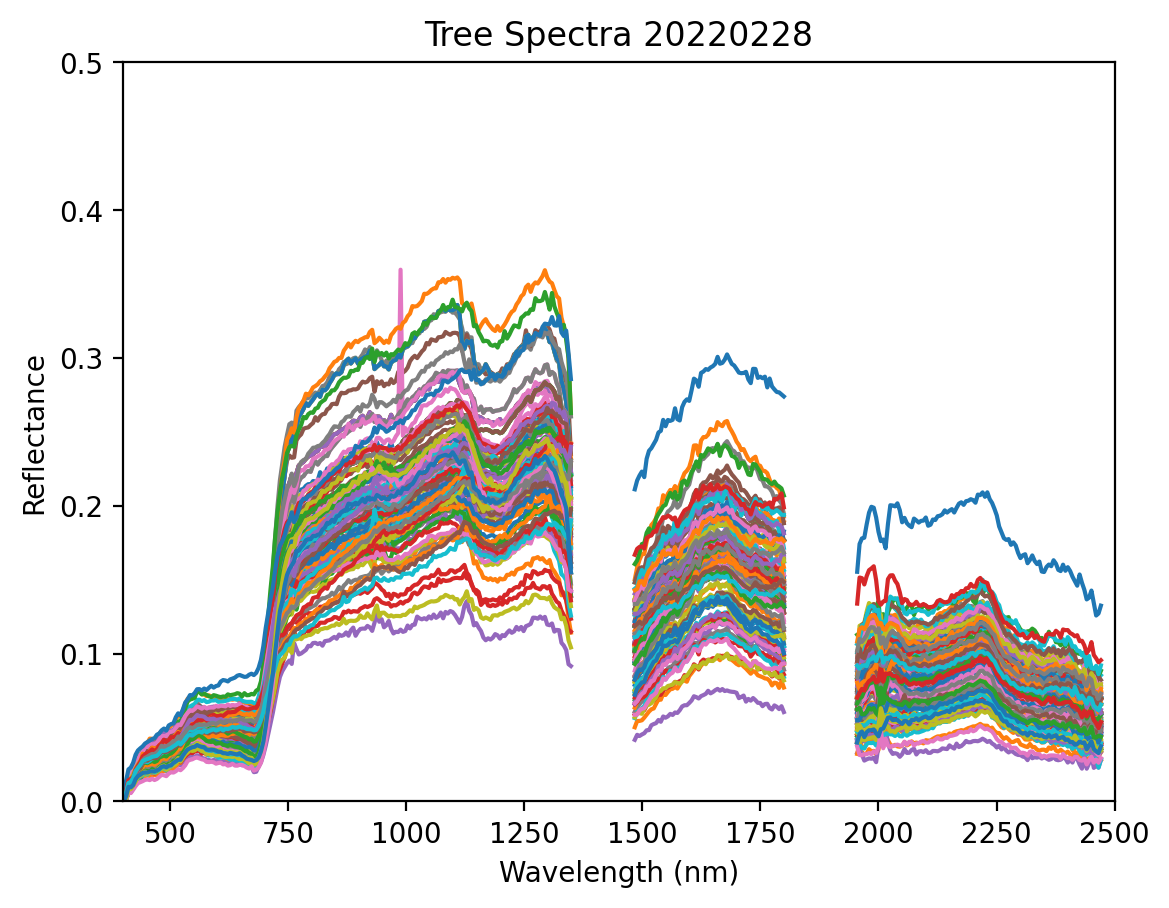

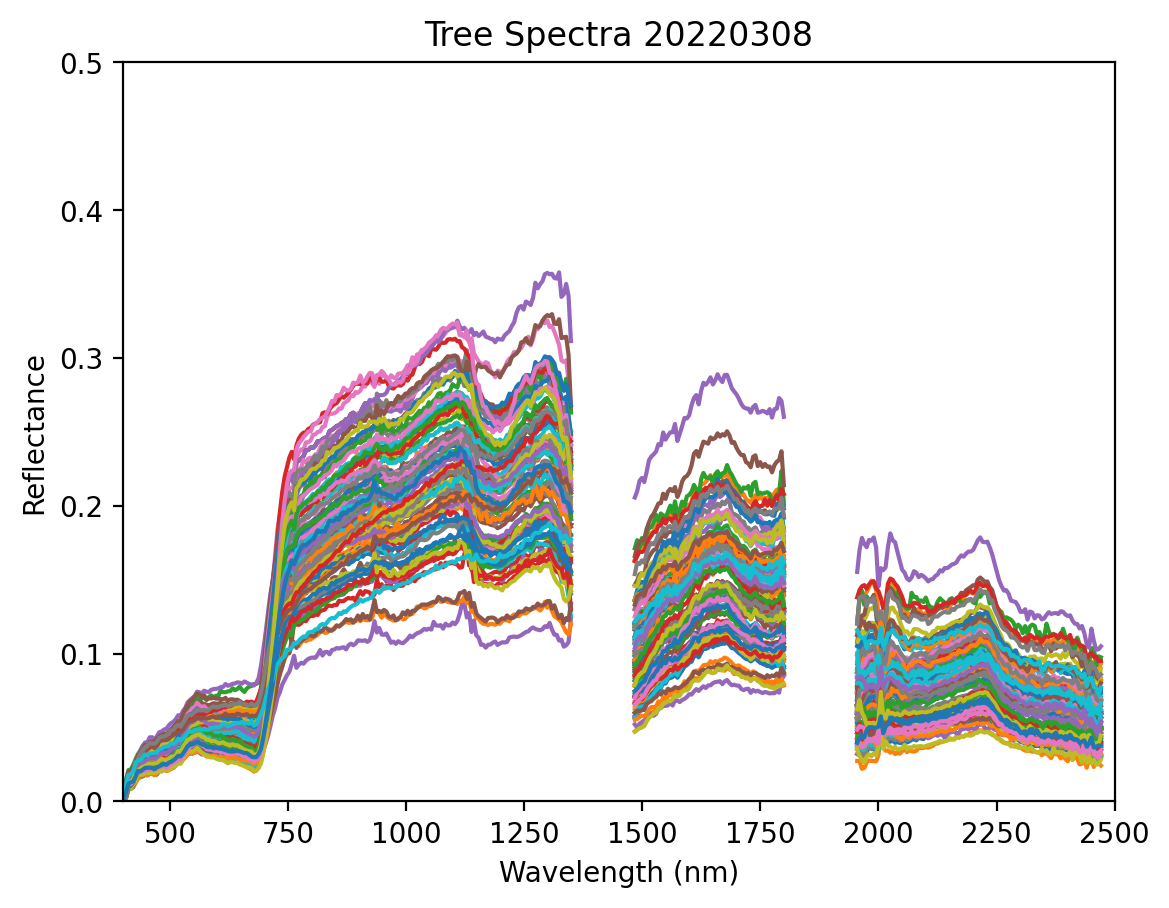

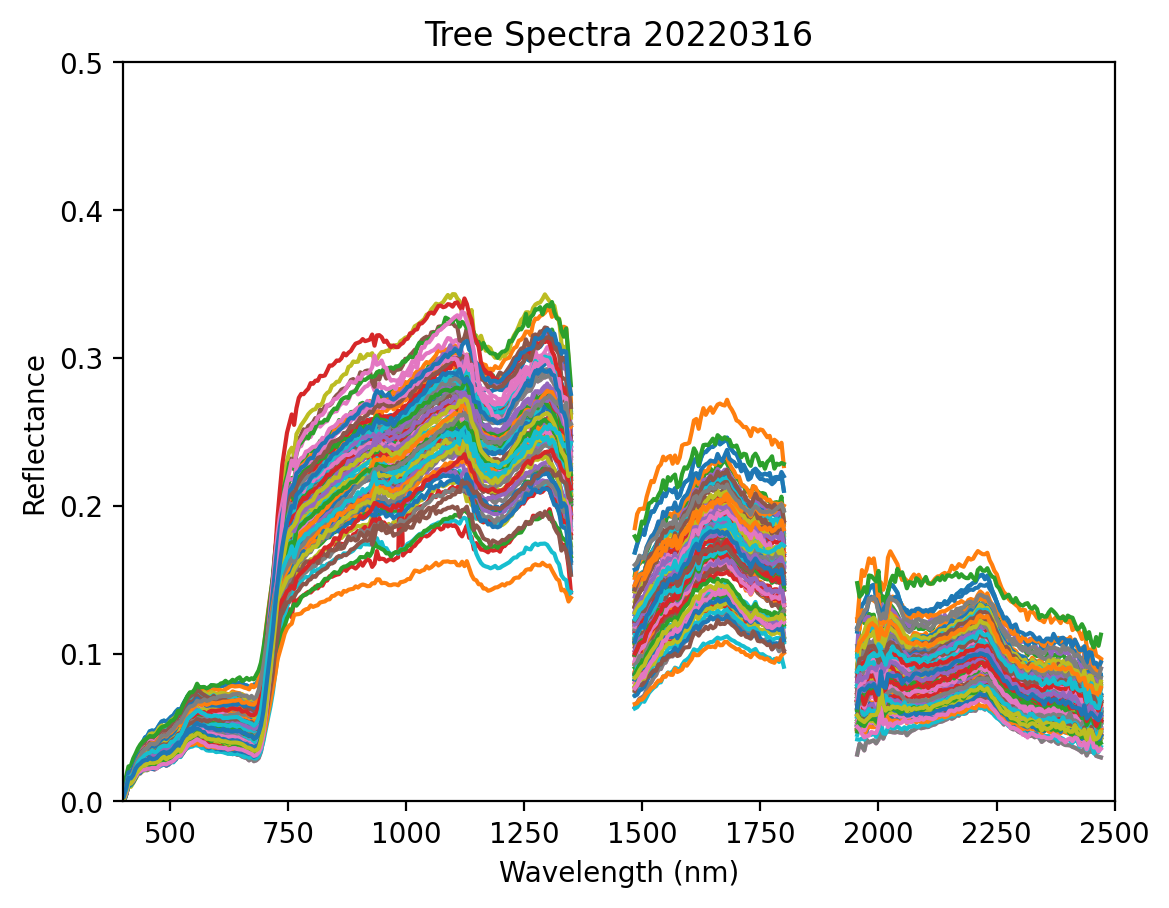

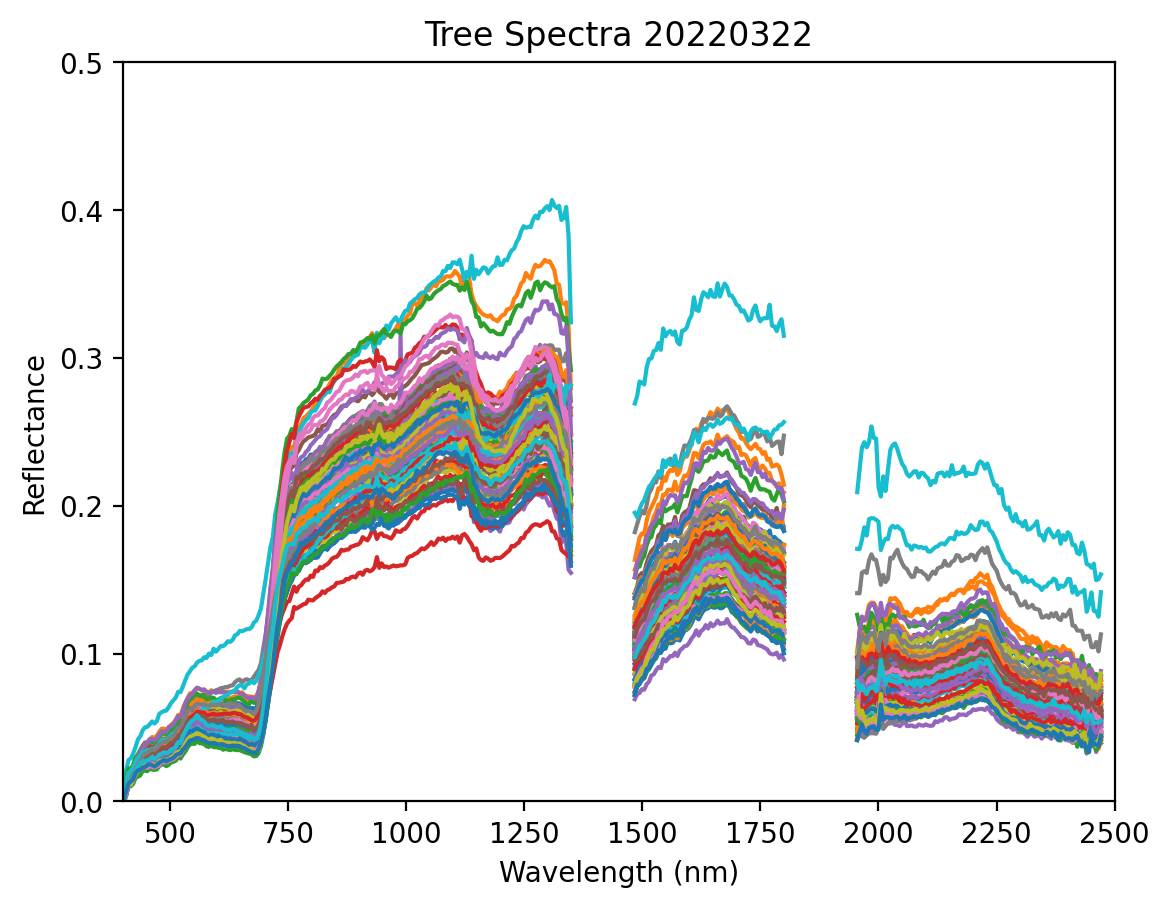

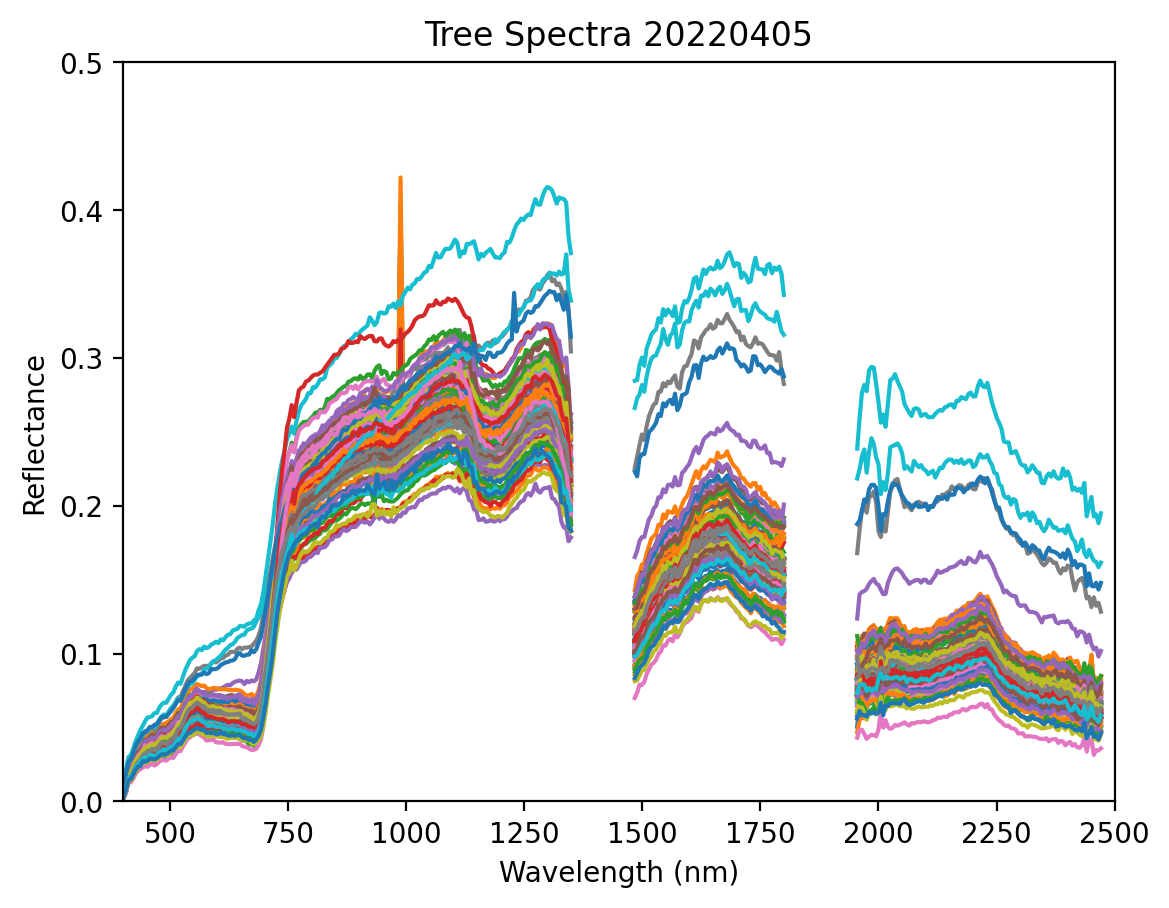

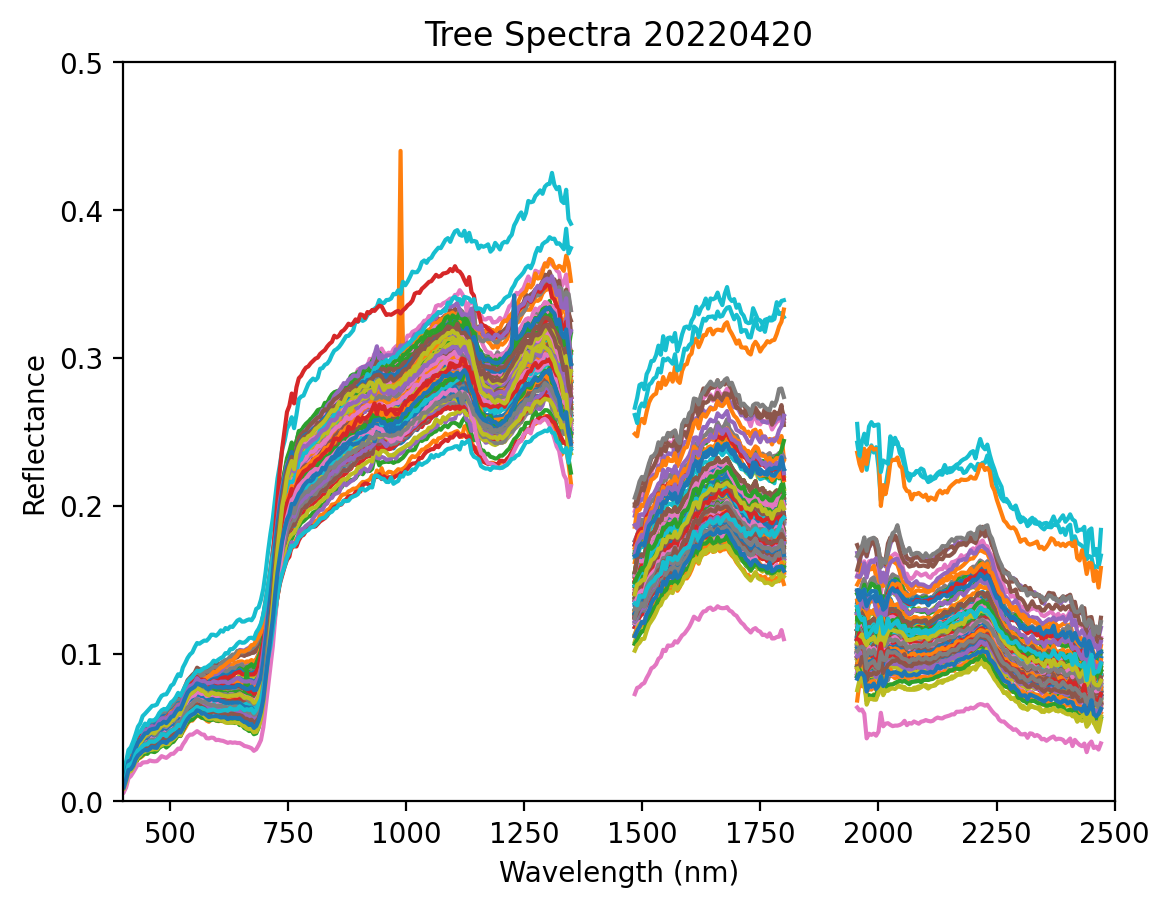

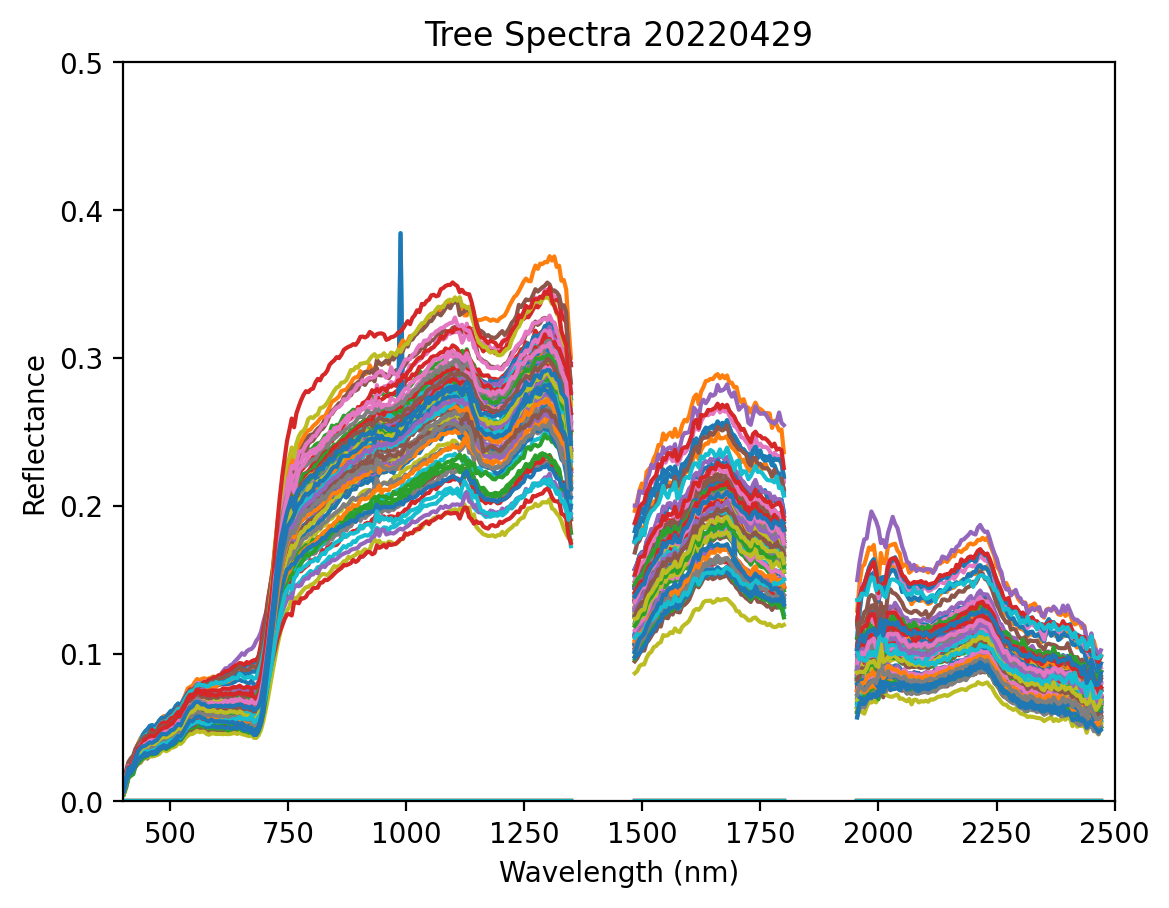

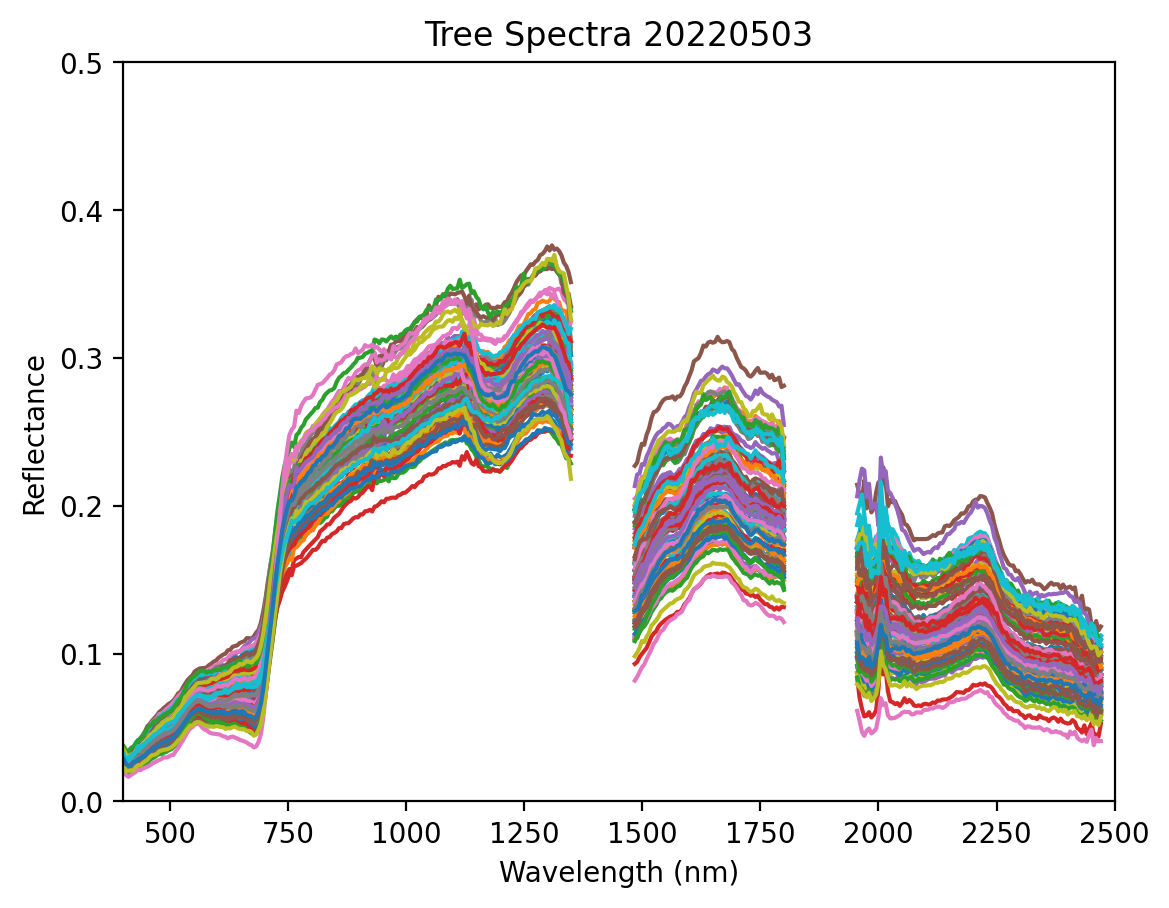

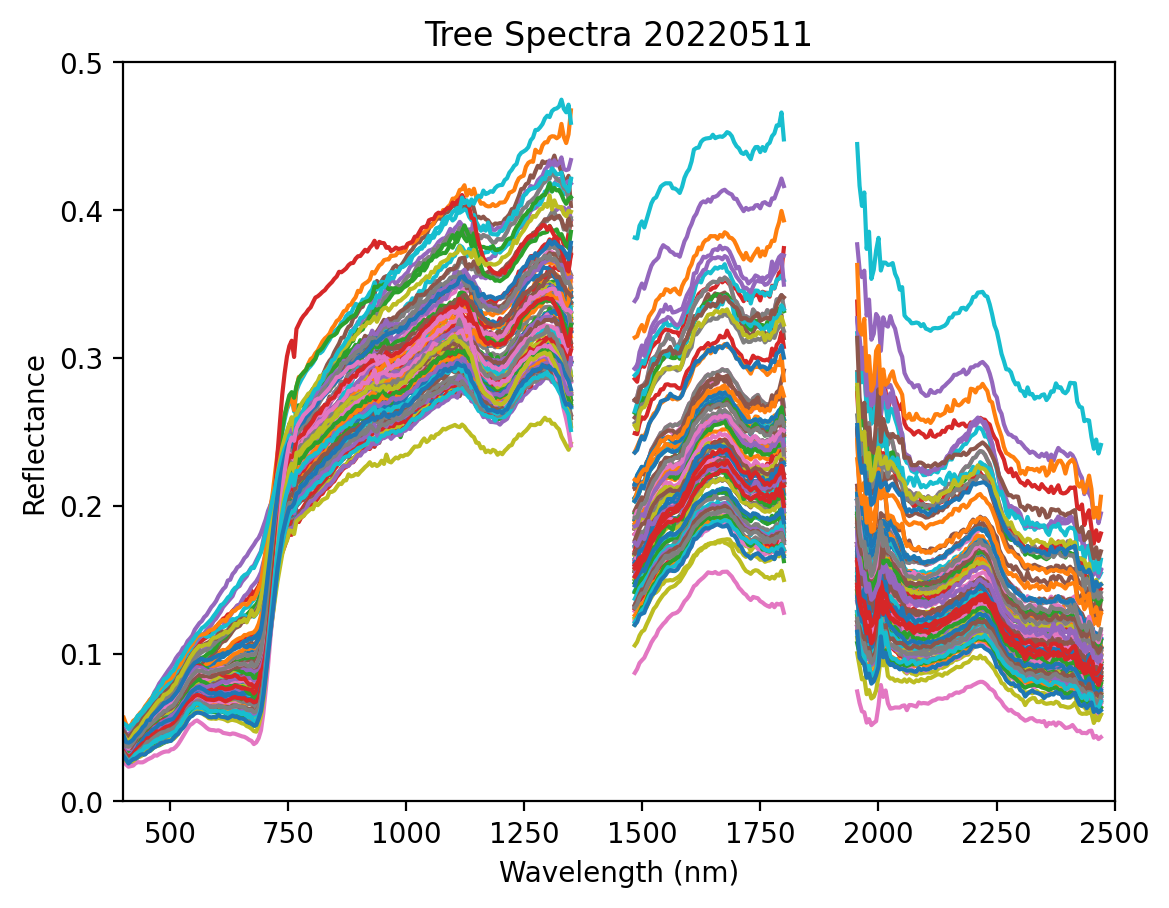

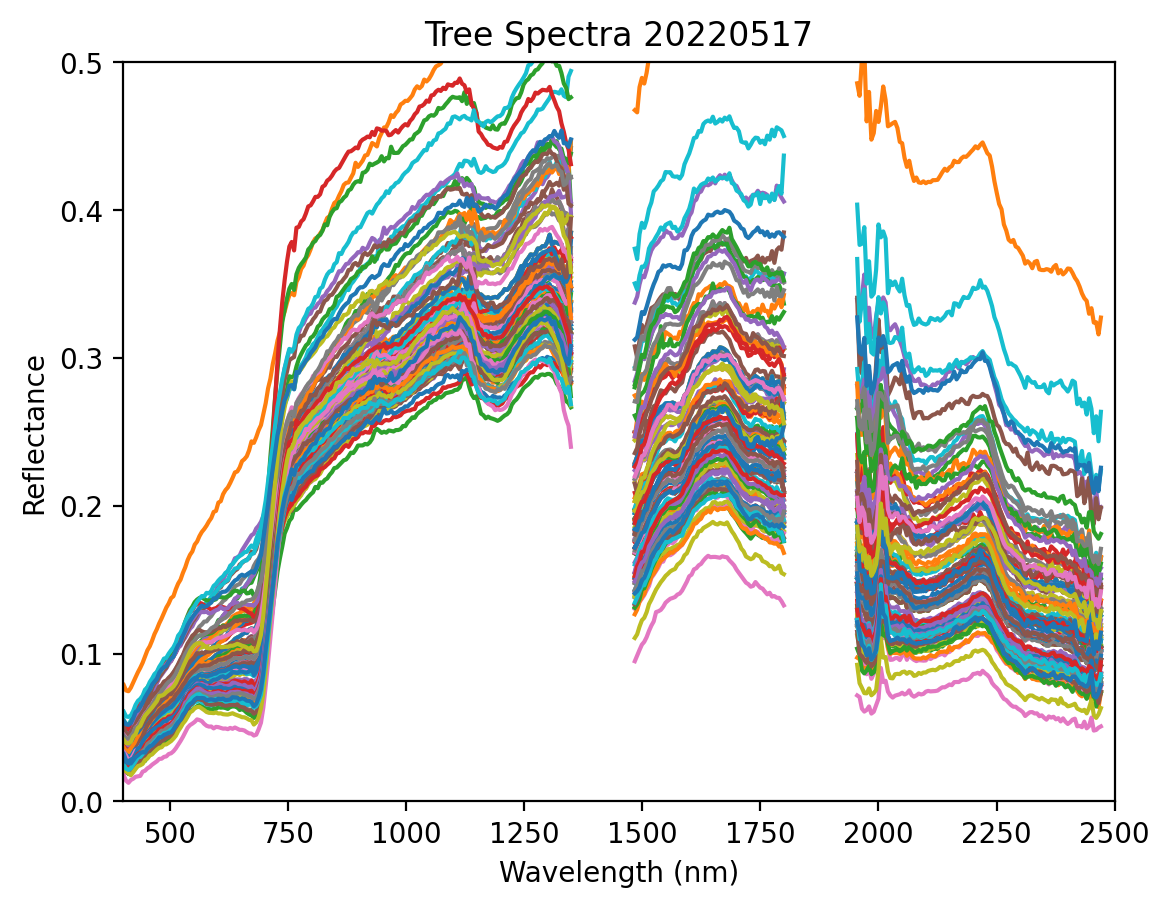

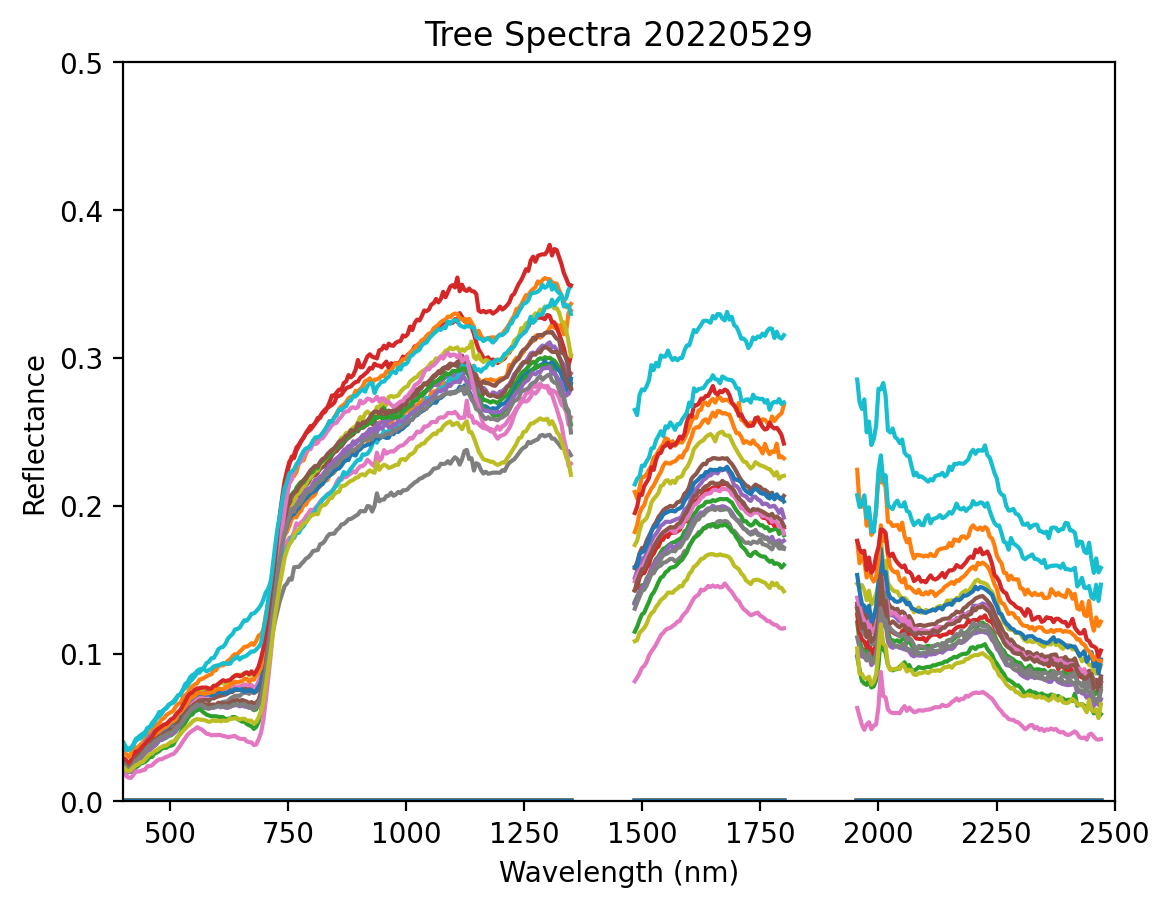

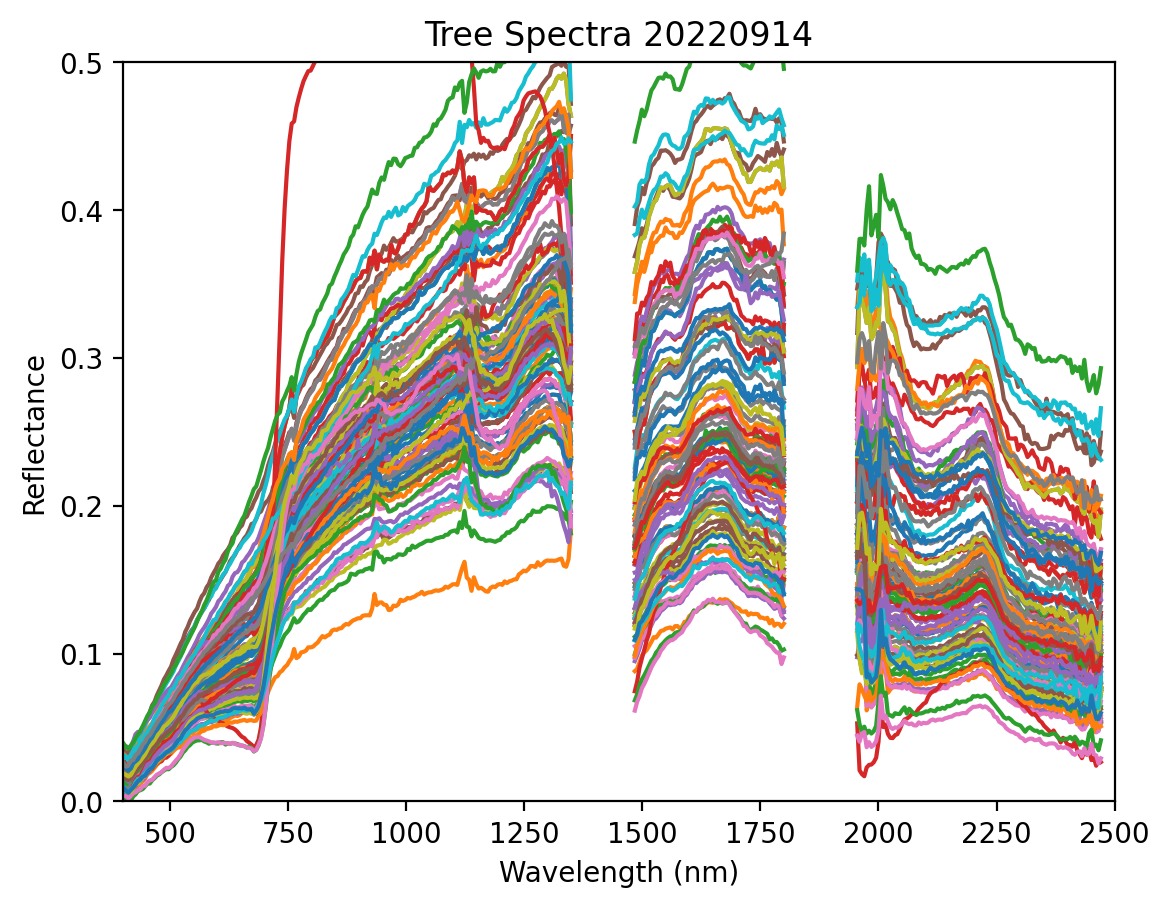

In [22]:
for date in date_list:
    
    glt_list = [glt for glt in all_glts if glt[3:11] == date]
    img_list = [img for img in all_imgs if img[3:11] == date]

    # Get spectra for all trees
    spectra = shapefile_to_spectra(trees_shp_path, [os.path.join(img_dir, img) for img in img_list], [os.path.join(glt_dir, glt) for glt in glt_list]) 

    spectra[0].to_csv(f'D:/SHIFT/extracted_data/spectra/{date}_tree_spectra.csv')

    trees = gpd.read_file(trees_shp_path).rename(columns={'Comment': 'Tree_ID'})
    trees['GLTs'] = spectra[1]
    trees['Latitude'] = trees.geometry.y
    trees['Longitude'] = trees.geometry.x
    trees[['Tree_ID', 'Latitude', 'Longitude', 'GLTs']].to_csv(f'D:/SHIFT/extracted_data/spectra/{date}_tree_spectra_metadata.csv', index=False)

    wavelengths = spectra[0].index.to_numpy()
    wl_nan = wavelengths.copy()
    wl_nan[wavelengths < 400] = np.nan 
    wl_nan[wavelengths > 2475] = np.nan 
    wl_nan[np.logical_and(wavelengths > 1350, wavelengths < 1480)] = np.nan 
    wl_nan[np.logical_and(wavelengths > 1800, wavelengths < 1950)] = np.nan 
    for tree in spectra[0].columns:
        plt.plot(wl_nan, spectra[0][tree], label=tree)

    plt.xlim(400, 2500)
    plt.ylim(0, 0.5)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Tree Spectra '+date)
    plt.show()

## 5. Extracting Neighboring Spectra for Uncertainty

In [9]:
# Returns a dataframe containing a spectra for a given point, plus the spectra of the 8 pixels surrounding it
def get_pixel_value_and_neighbors(image_path, glt_path, lat, lon, coords_epsg):
    image = rxr.open_rasterio(image_path)
    glt = rxr.open_rasterio(glt_path)
    glt_epsg = glt.rio.crs.to_epsg()
    if glt_epsg != coords_epsg:    # if the GLT and the input coordinates are in different projections, convert the coordinates to the GLT projection
        coords = gpd.GeoDataFrame({'geometry': gpd.points_from_xy([lon], [lat])}, crs=coords_epsg)
        coords = coords.to_crs(glt_epsg)
        lat = coords.geometry.y[0]
        lon = coords.geometry.x[0]
    closest_point = glt.sel(x=lon+2.4, y=lat+2.4, method='nearest', tolerance=2.5)
    closest_x = int(closest_point[0].values[()])-1
    closest_y = int(closest_point[1].values[()])-1
    pixel_value = image.isel(x=closest_x, y=closest_y).values
    pixel_value_N1 = image.isel(x=closest_x, y=closest_y+1).values
    pixel_value_N2 = image.isel(x=closest_x, y=closest_y-1).values
    pixel_value_N3 = image.isel(x=closest_x+1, y=closest_y).values
    pixel_value_N4 = image.isel(x=closest_x-1, y=closest_y).values
    pixel_value_N5 = image.isel(x=closest_x-1, y=closest_y-1).values
    pixel_value_N6 = image.isel(x=closest_x-1, y=closest_y+1).values
    pixel_value_N7 = image.isel(x=closest_x+1, y=closest_y+1).values
    pixel_value_N8 = image.isel(x=closest_x+1, y=closest_y-1).values
    df = pd.DataFrame({'Pixel Value': pixel_value, 'N1': pixel_value_N1, 'N2': pixel_value_N2, 'N3': pixel_value_N3, 'N4': pixel_value_N4, 'N5': pixel_value_N5, 'N6': pixel_value_N6, 'N7': pixel_value_N7, 'N8': pixel_value_N8})
    df = df.set_index(image.wavelength.values)
    return df

In [10]:
tree_list = gpd.read_file(trees_shp_path).rename(columns={'Comment': 'Tree_ID'})

# delete question mark characters from tree IDs
tree_list['Tree_ID'] = tree_list['Tree_ID'].str.replace('?', '')

for date in date_list:
    if not os.path.exists(f'D:/SHIFT/extracted_data/spectra_with_neighbors/{date}'):
        os.makedirs(f'D:/SHIFT/extracted_data/spectra_with_neighbors/{date}')
    glt_list = [glt for glt in all_glts if glt[3:11] == date]
    img_list = [img for img in all_imgs if img[3:11] == date]

    glt_list.sort()
    img_list.sort()
    
    for i in range(len(tree_list)):
        lat = tree_list.geometry.y[i]
        lon = tree_list.geometry.x[i]
        for j in range(len(img_list)):
            try:
                df = get_pixel_value_and_neighbors(os.path.join(img_dir, img_list[j]), os.path.join(glt_dir, glt_list[j]), lat, lon, tree_list.crs.to_epsg())
                df.to_csv(f'D:/SHIFT/extracted_data/spectra_with_neighbors/{date}/{tree_list.Tree_ID[i]}_{date}_{img_list[j]}.csv')
            except IndexError:
                continue